# Convert raw ndjson into sketch-rnn format with variable RDP epsilon

This notebook will convert `.ndjson` files into the `.npz` files one can use to train [sketch-rnn](https://otoro.net/sketch-rnn). We set the target length to be 200 steps, and vary epsilon parameters to control the granuarity of the RDP algorithm.

To download an `.ndjson` file, try:

```
wget https://storage.googleapis.com/quickdraw_dataset/full/raw/jail.ndjson
```

To download the `jail` class from [QuickDraw](https://github.com/googlecreativelab/quickdraw-dataset)

And we assume it is saved in a subdir called `/ndjson` for this notebook.

After the `npz` dataset is generated, we can train sketch-rnn with a command like this:

```
python sketch_rnn_train.py --data_dir=dir_where_npz_file_is --gpu=0 --log_root=log_jail --hparams=data_set=['jail.200.npz'],num_steps=1000000,conditional=0,dec_rnn_size=1024,recurrent_dropout_prob=0.8
```

In [1]:
# notebook to convert raw quickdraw data using incremental RDP to fit everything within, say, 300 datapoints but not sacrifice quality.

import numpy as np
import util as util
import os
import json
import time
import random
from rdp import rdp

np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [2]:
def raw_to_lines(raw, epsilon=0.25):
  result = []
  N = len(raw)
  for i in range(N):
    line = []
    rawline = raw[i]
    M = len(rawline[0])
    if M <= 2:
      continue
    for j in range(M):
      line.append([rawline[0][j], rawline[1][j]])
    line = rdp(line, epsilon=epsilon) 
    result.append(line)
  return result

In [3]:
# config
NAME = "jail"
TARGET = 200

In [4]:
raw_file = open('ndjson/'+NAME+'.ndjson', 'r') 
raw_lines = raw_file.readlines() 

In [5]:
num_drawings = len(raw_lines)
print(num_drawings)

120131


In [6]:
all_strokes = []
for i in range(num_drawings):
  raw_drawing = json.loads(raw_lines[i])['drawing']
  lines = raw_to_lines(raw_drawing)
  strokes = util.lines_to_strokes(lines)
  if i % 1000 == 0:
    print("i", i)
  if len(strokes) < 20:
    continue
  strokes[0, 0] = 0
  strokes[0, 1] = 0
  all_strokes.append(strokes)
random.shuffle(all_strokes)

i 0
i 1000
i 2000
i 3000
i 4000
i 5000
i 6000
i 7000
i 8000
i 9000
i 10000
i 11000
i 12000
i 13000
i 14000
i 15000
i 16000
i 17000
i 18000
i 19000
i 20000
i 21000
i 22000
i 23000
i 24000
i 25000
i 26000
i 27000
i 28000
i 29000
i 30000
i 31000
i 32000
i 33000
i 34000
i 35000
i 36000
i 37000
i 38000
i 39000
i 40000
i 41000
i 42000
i 43000
i 44000
i 45000
i 46000
i 47000
i 48000
i 49000
i 50000
i 51000
i 52000
i 53000
i 54000
i 55000
i 56000
i 57000
i 58000
i 59000
i 60000
i 61000
i 62000
i 63000
i 64000
i 65000
i 66000
i 67000
i 68000
i 69000
i 70000
i 71000
i 72000
i 73000
i 74000
i 75000
i 76000
i 77000
i 78000
i 79000
i 80000
i 81000
i 82000
i 83000
i 84000
i 85000
i 86000
i 87000
i 88000
i 89000
i 90000
i 91000
i 92000
i 93000
i 94000
i 95000
i 96000
i 97000
i 98000
i 99000
i 100000
i 101000
i 102000
i 103000
i 104000
i 105000
i 106000
i 107000
i 108000
i 109000
i 110000
i 111000
i 112000
i 113000
i 114000
i 115000
i 116000
i 117000
i 118000
i 119000
i 120000


In [7]:
len(all_strokes)

119693

In [8]:
np.savez_compressed(NAME+".npz", rawdata=all_strokes)

In [9]:
print(util.get_min_len(all_strokes))
print(util.get_max_len(all_strokes))

20
2301


In [10]:
def further_simplify(temp_strokes, epsilon=0.5):
  temp_lines = util.strokes_to_lines(temp_strokes)
  new_lines = []
  for i in range(len(temp_lines)):
    temp_line = temp_lines[i]
    new_line = rdp(temp_line, epsilon)
    if len(new_line) > 2:
      new_lines.append(new_line)
  return util.lines_to_strokes(new_lines)

In [11]:
for i in range(10000):
  the_strokes = random.choice(all_strokes)
  if len(the_strokes) > 800:
    break
print(len(the_strokes))

822


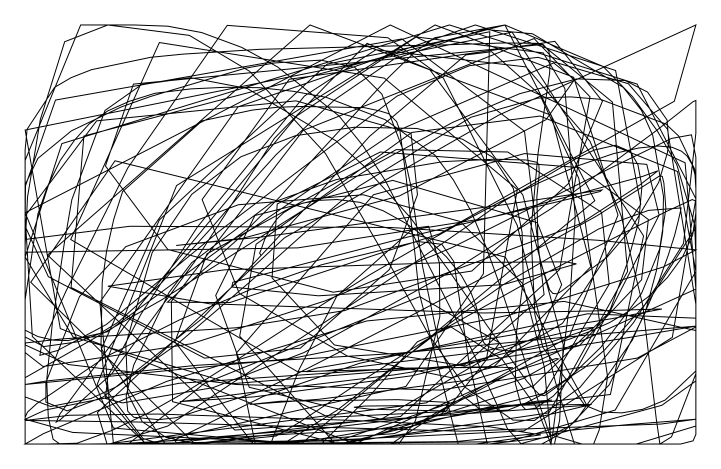

In [12]:
util.draw_strokes(the_strokes, factor=2.5)

682


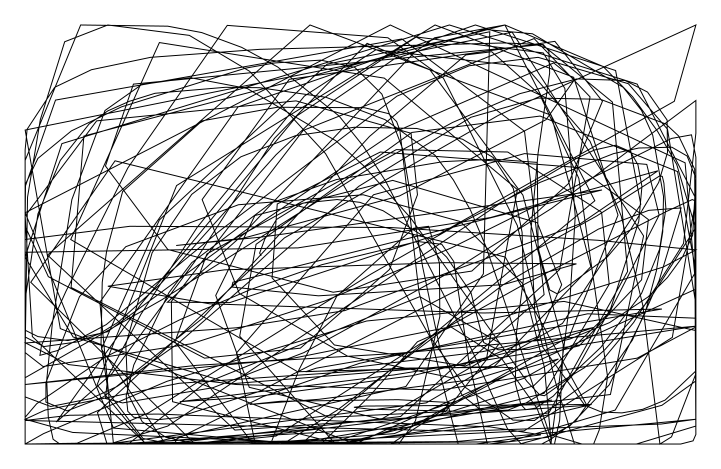

In [13]:
simplified_strokes = further_simplify(the_strokes, 5.0)
print(len(simplified_strokes))
util.draw_strokes(simplified_strokes, factor=2.5)

In [14]:
for j in range(1, 20):
  eps = j/4.0+0.25
  print(eps)

0.5
0.75
1.0
1.25
1.5
1.75
2.0
2.25
2.5
2.75
3.0
3.25
3.5
3.75
4.0
4.25
4.5
4.75
5.0


In [15]:
processed_strokes = []
for i in range(len(all_strokes)):
  if ((i+1) % 1000 == 0):
    print(i+1)
  this_strokes = all_strokes[i]
  if len(this_strokes) < TARGET:
    processed_strokes.append(this_strokes)
  else:
    for j in range(1, 9):
      eps = j/4.0+0.25
      simplified_strokes = further_simplify(this_strokes, eps)
      if len(simplified_strokes) <= TARGET:
        break
    if len(simplified_strokes) > TARGET:
      print("oops", i, len(simplified_strokes))
    else:
      processed_strokes.append(simplified_strokes)

1000
oops 1163 220
2000
oops 2024 208
oops 2312 215
3000
4000
oops 4407 291
5000
6000
7000
oops 7164 272
oops 7675 268
8000
oops 8668 320
oops 8789 284
9000
oops 9429 202
oops 9918 226
10000
oops 10642 209
oops 10650 256
11000
oops 11381 266
12000
oops 12239 207
13000
14000
oops 14666 253
15000
oops 15148 383
oops 15253 438
oops 15381 269
oops 15637 212
oops 15882 497
16000
oops 16007 326
oops 16871 231
17000
oops 17692 201
18000
19000
oops 19089 252
20000
21000
oops 21003 521
oops 21433 212
oops 21614 201
oops 21730 386
oops 21875 227
22000
oops 22939 281
oops 22945 223
23000
oops 23209 289
oops 23276 243
24000
oops 24332 208
25000
oops 25005 228
oops 25058 454
oops 25861 245
26000
oops 26543 222
oops 26889 461
27000
28000
oops 28279 757
29000
oops 29475 286
oops 29486 333
oops 29522 255
30000
oops 30780 668
oops 30877 512
oops 30906 237
31000
oops 31053 614
oops 31213 241
32000
33000
34000
oops 34758 360
35000
oops 35027 253
oops 35072 233
oops 35244 231
36000
oops 36481 323
37000
oo

119498
159


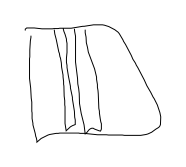

In [16]:
print(len(processed_strokes))
this_strokes = random.choice(processed_strokes)
print(len(this_strokes))
util.draw_strokes(this_strokes, factor=3.5)

In [17]:
np.savez_compressed("processed_"+NAME+".npz", rawdata=processed_strokes)

In [18]:
N = len(processed_strokes)
print(N)

119498


In [19]:
np.savez_compressed(NAME+"."+str(TARGET)+".npz", train=processed_strokes[0:N-5000],valid=processed_strokes[N-5000:N-2000], test=processed_strokes[N-2000:])

In [20]:
filename = NAME+"."+str(TARGET)+".npz"

In [21]:
load_data = np.load(filename, allow_pickle=True)
train_set = load_data['train']
valid_set = load_data['valid']
test_set = load_data['test']
print(util.get_min_len(train_set))
print(util.get_max_len(train_set))

20
200


In [22]:
len(train_set)

114498

In [23]:
len(valid_set)

3000

In [24]:
len(test_set)

2000

86


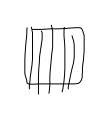

In [25]:
this_strokes = random.choice(train_set)
print(len(this_strokes))
util.draw_strokes(this_strokes, factor=3.5)

182


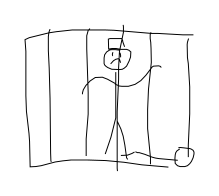

In [26]:
this_strokes = random.choice(train_set)
print(len(this_strokes))
util.draw_strokes(this_strokes, factor=3.5)

167


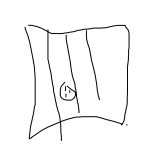

In [27]:
this_strokes = random.choice(train_set)
print(len(this_strokes))
util.draw_strokes(this_strokes, factor=3.5)

In [ ]:
this_strokes = random.choice(train_set)
print(len(this_strokes))
util.draw_strokes(this_strokes, factor=3.5)